In [154]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz

def get_sample(df,n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def proc_df(df,y_fid, skip_flds = None, do_scale = False, na_dict = None, preproc_fn=None, max_n_cat = None, subset = None, mapper = None):
    if not skip_fids : skip_fids = []
    if subset : df = get_sample(df,subset)
    df = df.copy()
    if preproc_fn : preproc_fn(df)
    y = df[y_fld].values
    df.drop(skip_flds+[y_fld], axis = 1, inplace=True)
    
    if na_dict is None : na_dict = {}
    for n,c in df.items(): na_dict = {}
    if do_scale : mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    res = [pd.get_dummies(df, dummy_na = True), y, na_dict]
    if do_scale : res = res+ [mapper]
    return res

def rf_feat_importance(m,df):
    return pd.DataFrame({'cols':df.columns, 'imp' : m.feature_importances_}).sort_values('imp', ascending = False)

def set_rf_samples(n):
    forest._generate_sample_indices = (lambda rs, n_samples: forest.check_random_state(rs).randint(0, n_samples, n_samples))
    
def reset_rf_samples():
    forest._generate_sample_indices = (lambda rs, n_samples: forest.check_random_state(rs).randint(0, n_samples, n_samples))                                     


In [155]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
from pdpbox import pdp
from plotnine import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

import sklearn
from sklearn import metrics
from scipy.cluster import hierarchy as hc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [156]:
train = pd.read_csv('train_V2.csv')
test = pd.read_csv('test_V2.csv')

In [157]:
print('First 5 rows : ')
display(train.head())

print('Last 5 rows : ')
display(train.tail())

First 5 rows : 


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


Last 5 rows : 


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,...,0,1292.0,0,0.000,0,0,1019.0,3,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,...,0,0.0,0,0.000,0,0,81.7,6,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,...,0,0.0,0,2.184,0,0,788.7,4,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,...,2,0.0,0,0.000,0,0,2748.0,8,0,0.8000
4446965,0d8e7ed728b6fd,8c74f72fedf5ff,62a16aabcc095c,0,2,268.00,0,0,1,18,...,0,1369.0,0,0.000,0,0,1244.0,5,0,0.5464


In [158]:
train.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,...,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.338149e-01,1.106908e+00,1.307171e+02,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,5.050060e+02,9.247833e-01,5.439551e-01,...,1.646590e-01,6.061157e+02,3.496091e-03,4.509322e+00,2.386841e-02,7.918208e-03,1.154218e+03,3.660488e+00,6.064601e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,6.275049e+02,1.558445e+00,7.109721e-01,...,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261157e-02,1.183497e+03,2.456544e+00,7.397004e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,...,0.000000e+00,1.909750e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,...,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


In [159]:
train.info()

print('Shape of training set : ', train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB
Shape of training set :  (4446966, 29)


In [160]:
train[train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [161]:
train.drop(2744604, inplace=True)

In [162]:
train[train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc


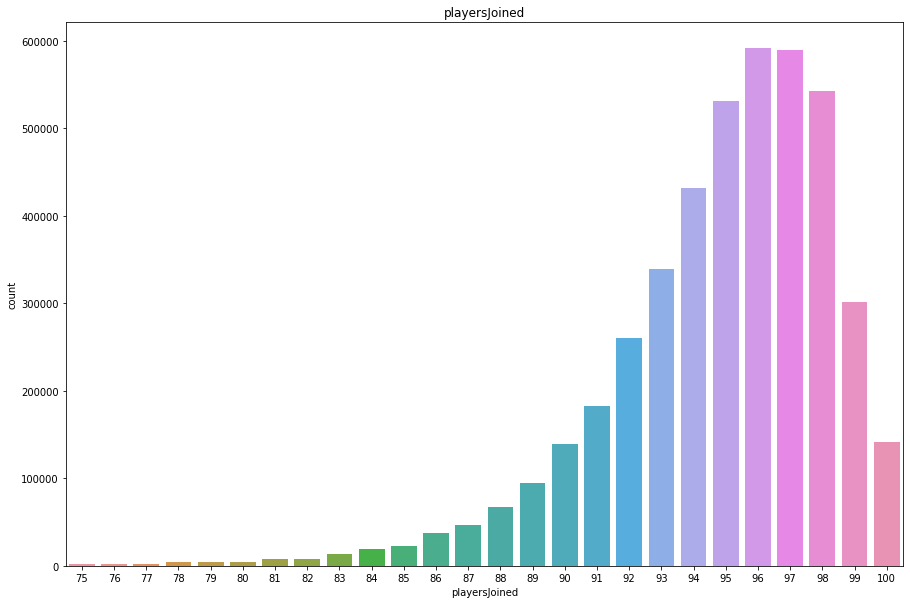

In [163]:
train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')
plt.figure(figsize = (15,10))
sns.countplot(train[train['playersJoined']>= 75]['playersJoined'])
plt.title('playersJoined')
plt.show()

In [164]:
train['killsNorm'] = train['kills'] * ((100-train['playersJoined'])/100+1)
train['damageDealtNorm'] = train['damageDealt']*((100-train['playersJoined'])/100 + 1)
train['maxPlaceNorm'] = train['maxPlace']*((100-train['playersJoined'])/100+1)
train['matchDurationNorm'] = train['matchDuration']*((100-train['playersJoined'])/100+1)
to_show = ['Id', 'kills','killsNorm','damageDealt','damageDealtNorm','maxPlace','maxPlaceNorm','matchDuration','matchDurationNorm']
train[to_show][0:11]

,Id,kills,killsNorm,damageDealt,damageDealtNorm,maxPlace,maxPlaceNorm,matchDuration,matchDurationNorm
0,7f96b2f878858a,0,0.00,0.000,0.00000,28,29.12,1306,1358.24
1,eef90569b9d03c,0,0.00,91.470,99.70230,26,28.34,1777,1936.93
2,1eaf90ac73de72,0,0.00,68.000,69.36000,50,51.00,1318,1344.36
3,4616d365dd2853,0,0.00,32.900,35.86100,31,33.79,1436,1565.24
4,315c96c26c9aac,1,1.03,100.000,103.00000,97,99.91,1424,1466.72
5,ff79c12f326506,1,1.05,100.000,105.00000,28,29.40,1395,1464.75
6,95959be0e21ca3,0,0.00,0.000,0.00000,28,28.84,1316,1355.48
7,311b84c6ff4390,0,0.00,8.538,8.87952,96,99.84,1967,2045.68
8,1a68204ccf9891,0,0.00,51.600,53.14800,28,28.84,1375,1416.25
9,e5bb5a43587253,0,0.00,37.270,38.38810,29,29.87,1930,1987.90


In [165]:
train['healsandboosts'] = train['heals'] + train['boosts']
train[['heals', 'boosts','healsandboosts']].tail()

,heals,boosts,healsandboosts
4446961,0,0,0
4446962,0,1,1
4446963,0,0,0
4446964,2,4,6
4446965,1,2,3


In [166]:
train['totalDistance'] = train['rideDistance'] + train['walkDistance'] + train['swimDistance'] 

train['killsWithoutMoving'] = ((train['kills'] > 0) & (train['totalDistance'] == 0))

In [167]:
train['headshot_rate'] = train['headshotKills'] / train['kills']
train['headshot_rate'] = train['headshot_rate'].fillna(0)

In [168]:
display(train[train['killsWithoutMoving']==True].shape)
train[train['killsWithoutMoving'] == True].head(10)

(1535, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.00,0,0,3,18,...,0.8571,58,8.52,842.0600,21.30,842.06,3,0.0,True,0.000000
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.60,0,0,6,33,...,0.6000,42,4.74,547.6280,17.38,2834.52,6,0.0,True,0.000000
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.00,0,4,5,3,...,0.8947,21,35.80,3132.5000,35.80,1607.42,5,0.0,True,0.200000
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.80,0,0,0,69,...,0.0000,73,1.27,200.4060,24.13,1014.73,0,0.0,True,0.000000
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.00,0,1,0,37,...,0.3000,42,1.58,158.0000,17.38,2834.52,0,0.0,True,1.000000
20881,40871bf43ddac7,2cea046b7d1dce,0600f86f11c6e4,0,0,506.10,4,1,3,7,...,0.8000,44,9.36,789.5160,9.36,909.48,3,0.0,True,0.166667
23298,b950836d0427da,1f735b1e00d549,ad860f4e162bbc,1,0,1124.00,0,4,1,7,...,0.6000,48,18.24,1708.4800,9.12,836.00,1,0.0,True,0.333333
24640,aeced11d46de19,d4009ffa95bb4f,73f3ed869c9171,2,0,529.90,0,2,11,12,...,0.8571,57,10.01,757.7570,21.45,856.57,11,0.0,True,0.285714
25659,6626c4d47cffa0,ee3fe5c0d917c3,341341834b7941,0,1,128.90,0,1,6,53,...,0.2857,61,2.78,179.1710,11.12,1017.48,7,0.0,True,0.500000
30079,869331b90bfa3f,869ea3ad036e53,fa373e28ff5062,0,0,85.56,0,0,0,46,...,0.8571,53,1.47,125.7732,22.05,1051.05,0,0.0,True,0.000000


In [169]:
train.drop(train[train['killsWithoutMoving'] == True].index, inplace=True)

In [170]:
train[train['roadKills'] > 10]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
2733926,c3e444f7d1289f,489dd6d1f2b3bb,4797482205aaa4,0,0,1246.0,0,0,0,1,...,0.4286,92,15.12,1345.68,99.36,1572.48,0,1282.302,False,0.000000
2767999,34193085975338,bd7d50fa305700,a22354d036b3d6,0,0,1102.0,0,0,0,1,...,0.4713,88,12.32,1234.24,98.56,2179.52,0,4934.600,False,0.000000
2890740,a3438934e3e535,1081c315a80d14,fe744430ac0070,0,8,2074.0,0,1,11,1,...,1.0000,38,32.40,3359.88,61.56,3191.40,19,5876.000,False,0.050000
3524413,9d9d044f81de72,8be97e1ba792e3,859e2c2db5b125,0,3,1866.0,0,5,7,1,...,0.9398,84,20.88,2164.56,97.44,2233.00,10,7853.000,False,0.277778


In [171]:
train.drop(train[train['roadKills'] > 10].index, inplace=True)

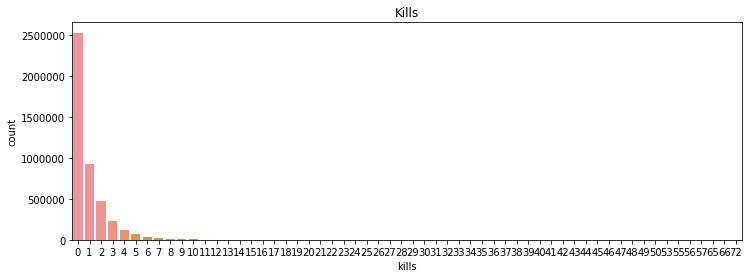

In [172]:
plt.figure(figsize= (12,4))
sns.countplot(data=train, x=train['kills']).set_title('Kills')
plt.show()

In [173]:
display(train[train['kills']>30].shape)
train[train['kills'] > 30].head(10)

(95, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
57978,9d8253e21ccbbd,ef7135ed856cd8,37f05e2a01015f,9,0,3725.0,0,7,0,2,...,0.8571,16,64.40,6854.00,14.72,3308.32,0,48.82,False,0.200000
87793,45f76442384931,b3627758941d34,37f05e2a01015f,8,0,3087.0,0,8,27,3,...,1.0000,16,57.04,5680.08,14.72,3308.32,27,780.70,False,0.258065
156599,746aa7eabf7c86,5723e7d8250da3,f900de1ec39fa5,21,0,5479.0,0,12,7,4,...,0.7000,11,90.72,10355.31,20.79,3398.22,7,23.71,False,0.250000
160254,15622257cb44e2,1a513eeecfe724,db413c7c48292c,1,0,4033.0,0,40,0,1,...,1.0000,62,57.96,5565.54,11.04,1164.72,0,718.30,False,0.952381
180189,1355613d43e2d0,f863cd38c61dbf,39c442628f5df5,5,0,3171.0,0,6,15,1,...,1.0000,11,66.15,5993.19,17.01,3394.44,15,71.51,False,0.171429
334400,810f2379261545,7f3e493ee71534,f900de1ec39fa5,20,0,6616.0,0,13,5,1,...,1.0000,11,122.85,12504.24,20.79,3398.22,5,1036.00,False,0.200000
353128,f3e9746e3ff151,4bc1f00f07b304,a9e84c456cc859,2,0,3834.0,0,9,5,1,...,1.0000,13,72.93,7169.58,24.31,3356.65,5,124.20,False,0.230769
457829,265e23756baa0b,9d94424171c2a1,664dee9ed8f646,3,0,2907.0,0,27,2,1,...,1.0000,38,53.46,4709.34,8.10,1339.74,2,382.40,False,0.818182
488335,31a0682922ef45,275a27a3ee4cc8,3037f74ef8a3a3,2,0,3055.0,0,9,0,1,...,1.0000,20,59.40,5499.00,32.40,1605.60,0,35.30,False,0.272727
662650,dd424a8b74bd49,ac9dea6d62f2e6,8a728def0644be,9,0,3454.0,38,9,4,1,...,0.2308,54,49.64,5042.84,20.44,1749.08,4,111.10,False,0.264706


In [174]:
train.drop(train[train['kills']>30].index, inplace=True)

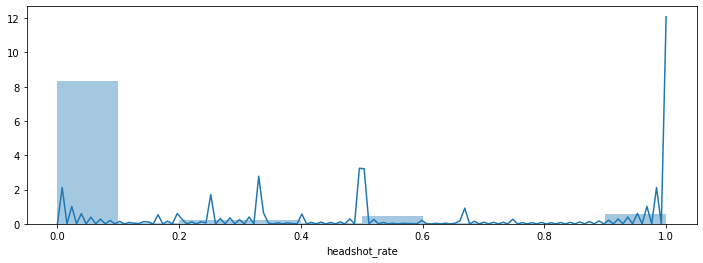

In [175]:
plt.figure(figsize = (12,4))
sns.distplot(train['headshot_rate'], bins=10)
plt.show()

In [176]:
display(train[(train['headshot_rate'] == 1) & (train['kills'] > 9)].shape)
train[(train['headshot_rate'] == 1)&(train['kills']>9)].head(10)

(24, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
281570,ab9d7168570927,add05ebde0214c,e016a873339c7b,2,3,1212.0,8,10,0,1,...,0.8462,93,10.70,1296.84,28.89,1522.61,3,2939.0,False,1.0
346124,044d18fc42fc75,fc1dbc2df6a887,628107d4c41084,3,5,1620.0,13,11,3,1,...,1.0000,96,11.44,1684.80,28.08,1796.08,8,8142.0,False,1.0
871244,e668a25f5488e3,5ba8feabfb2a23,f6e6581e03ba4f,0,4,1365.0,9,13,0,1,...,1.0000,98,13.26,1392.30,27.54,1280.10,4,2105.0,False,1.0
908815,566d8218b705aa,a9b056478d71b2,3a41552d553583,2,5,1535.0,10,10,3,1,...,0.9630,95,10.50,1611.75,29.40,1929.90,8,7948.0,False,1.0
963463,1bd6fd288df4f0,90584ffa22fe15,ba2de992ec7bb8,2,6,1355.0,12,10,2,1,...,1.0000,96,10.40,1409.20,28.08,1473.68,8,3476.0,False,1.0
1079403,1c245ed99b5f96,e42d09a9b8463a,5cec236bce68eb,0,5,1218.0,8,11,3,1,...,1.0000,95,11.55,1278.90,29.40,1912.05,8,8178.0,False,1.0
1167959,c4f80d4be5c561,b4a7892189b5dd,c7f7733ebbd447,0,4,1065.0,6,10,1,1,...,1.0000,97,10.30,1096.95,27.81,1283.38,5,2858.9,False,1.0
1348164,474a641f0a4bcb,2fdad3ca6fb3c0,114499c82f35d7,1,5,1319.0,11,12,1,1,...,1.0000,93,12.84,1411.33,29.96,1851.10,6,5963.0,False,1.0
1380385,202ce6a55119c5,2df66861f597b4,496700c29a5d44,1,4,1150.0,4,11,1,1,...,1.0000,88,12.32,1288.00,51.52,1397.76,5,3108.0,False,1.0
1483199,9d483f7cbb34d4,db5867bc814191,69495e3c478eb9,0,10,1478.0,8,13,2,1,...,1.0000,96,13.52,1537.12,50.96,1434.16,12,2479.8,False,1.0


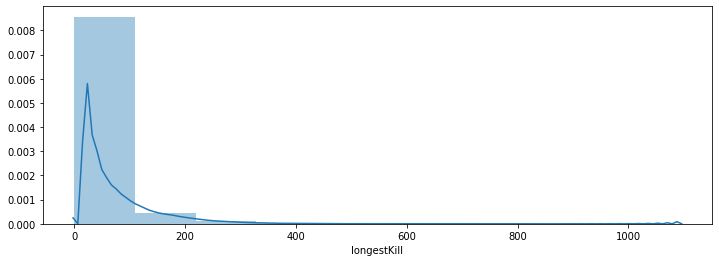

In [177]:
plt.figure(figsize = (12,4))
sns.distplot(train['longestKill'], bins=10)
plt.show()

In [178]:
display(train[train['longestKill']>=1000].shape)
train[train['longestKill']>=1000].head(10)

(20, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
202281,88e2af7d78af5a,34ddeede52c042,4346bc63bc67fa,0,3,783.9,5,1,1,5,...,0.9231,88,4.48,877.968,30.24,2087.68,4,3775.20,False,0.250000
240005,41c2f5c0699807,9faecf87ab4275,634edab75860b3,5,0,1284.0,8,5,7,18,...,0.5385,29,18.81,2195.640,23.94,2236.68,7,48.87,False,0.454545
324313,ef390c152bcc3d,30fd444be3bbc1,4f7f8d6cf558b4,2,0,1028.0,0,0,0,9,...,1.0000,51,14.90,1531.720,19.37,1040.02,0,2981.00,False,0.000000
656553,9948b058562163,c8cb8491112bf6,0104eeb664494d,6,0,1410.0,17,5,0,3,...,0.6000,41,25.44,2241.900,9.54,1734.69,0,29.21,False,0.312500
803632,4e7e6c74e3c57d,94698690918933,da91b0c3d875f8,0,0,196.8,0,0,0,51,...,0.0000,61,1.39,273.552,11.12,654.69,0,3159.00,False,0.000000
895411,1f5ba6e0cfb968,512ea24b831be3,5fb0d8b1fc16cf,4,0,1012.0,11,5,0,5,...,0.9091,86,11.40,1153.680,13.68,1163.94,0,569.50,False,0.500000
1172437,303a93cfa1f46c,8795d39fd0df86,9c8962b58bb3e3,2,1,329.3,0,0,2,45,...,0.2857,58,4.26,467.606,11.36,825.02,3,832.50,False,0.000000
1209416,528659ff1c1aec,7d1ba83423551d,ea9386587d5888,0,6,1640.0,0,7,0,1,...,0.9412,52,22.20,2427.200,76.96,1827.80,6,2848.00,False,0.466667
1642712,91966848e08e2f,0ee4fbd27657c9,17dea22cefe62a,3,2,2103.0,0,4,11,11,...,0.5000,28,39.56,3617.160,25.80,3092.56,13,235.30,False,0.173913
2015559,5ff0c1a9fab2ba,2d8119b1544f87,904cecf36217df,3,3,1302.0,0,6,5,15,...,0.6000,42,17.38,2057.160,17.38,2834.52,8,133.20,False,0.545455


In [179]:
train.drop(train[train['longestKill']>=1000].index, inplace = True)

In [180]:
train[['walkDistance', 'rideDistance','swimDistance','totalDistance']].describe()

,walkDistance,rideDistance,swimDistance,totalDistance
count,4.445311e+06,4.445311e+06,4.445311e+06,4.445311e+06
mean,1.154628e+03,6.063272e+02,4.510977e+00,1.765466e+03
std,1.183514e+03,1.498567e+03,3.050773e+01,2.183257e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.554000e+02,0.000000e+00,0.000000e+00,1.584000e+02
50%,6.864000e+02,0.000000e+00,0.000000e+00,7.893000e+02
75%,1.977000e+03,2.606500e-01,0.000000e+00,2.729000e+03
max,2.578000e+04,4.071000e+04,3.823000e+03,4.127010e+04


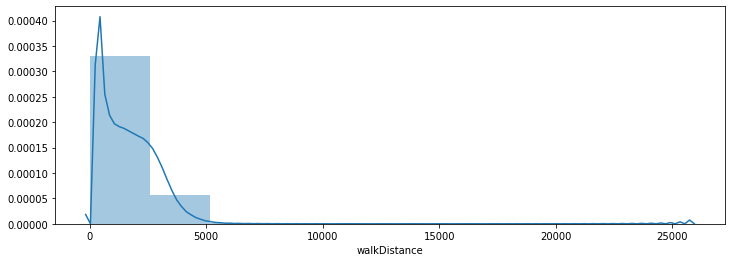

In [181]:
plt.figure(figsize=(12,4))
sns.distplot(train['walkDistance'], bins = 10)
plt.show()

In [182]:
display(train[train['walkDistance'] >=10000].shape)
train[train['walkDistance']>=10000].head(10)

(219, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
23026,8a6562381dd83f,23e638cd6eaf77,b0a804a610e9b0,0,1,0.00,0,0,0,44,...,0.8163,99,0.00,0.0000,99.99,1925.06,1,13540.3032,False,0.0
34344,5a591ecc957393,6717370b51c247,a15d93e7165b05,0,3,23.22,0,0,1,34,...,0.9474,65,0.00,31.3470,27.00,2668.95,4,10070.9073,False,0.0
49312,582685f487f0b4,338112cd12f1e7,d0afbf5c3a6dc9,0,4,117.20,1,0,1,24,...,0.9130,94,1.06,124.2320,49.82,2323.52,5,12446.7588,False,0.0
68590,8c0d9dd0b4463c,c963553dc937e9,926681ea721a47,0,1,32.34,0,0,1,46,...,0.8333,96,0.00,33.6336,50.96,1909.44,2,12483.6200,False,0.0
94400,d441bebd01db61,7e179b3366adb8,923b57b8b834cc,1,1,73.08,0,0,3,27,...,0.8194,73,0.00,92.8116,92.71,2293.62,4,11490.6300,False,0.0
125103,db5a0cdc969dcb,50cc466757950e,c306a9745c4c1d,0,4,37.73,0,0,7,47,...,0.7340,95,0.00,39.6165,99.75,2054.85,11,12828.7978,False,0.0
136421,955e60b09a96b1,30df08fe22a901,8669d01725f135,0,1,0.00,0,0,1,46,...,0.6957,94,0.00,0.0000,49.82,2091.38,2,12223.8100,False,0.0
136476,0d75d05b5c988c,3da040ce77cd0b,65bc5211a569dd,0,3,0.00,0,0,0,41,...,0.9333,91,0.00,0.0000,99.19,2028.49,3,14918.2000,False,0.0
154080,7e8a71d23381cd,e2c9f4f92840b2,a721de1aa05408,0,3,0.00,0,0,13,46,...,0.8602,94,0.00,0.0000,99.64,2038.38,16,12636.7000,False,0.0
154128,32fdde4c716787,390ae9a51c11b8,82610ed1b4d033,0,4,52.16,0,0,7,25,...,0.8936,95,1.05,54.7680,50.40,1927.80,11,10889.8614,False,0.0


In [183]:
train.drop(train[train['walkDistance']>=10000].index, inplace=True)

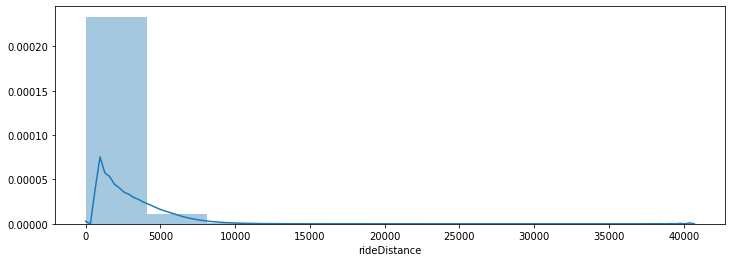

In [184]:
plt.figure(figsize = (12,4))
sns.distplot(train['rideDistance'],bins = 10)
plt.show()

In [185]:
display(train[train['rideDistance']>=20000].shape)
train[train['rideDistance']>=20000].head(10)

(150, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
28588,6260f7c49dc16f,b24589f02eedd7,6ebea3b4f55b4a,0,0,99.20,0,0,1,30,...,0.6421,96,1.04,103.1680,99.84,1969.76,1,26306.60,False,0.000000
63015,adb7dae4d0c10a,8ede98a241f30a,8b36eac66378e4,0,0,0.00,0,0,0,55,...,0.5376,94,0.00,0.0000,99.64,2004.46,0,22065.40,False,0.000000
70507,ca6fa339064d67,f7bb2e30c3461f,3bfd8d66edbeff,0,0,100.00,0,0,0,26,...,0.8878,99,1.01,101.0000,99.99,1947.28,0,28917.50,False,0.000000
72763,198e5894e68ff4,ccf47c82abb11f,d92bf8e696b61d,0,0,0.00,0,0,0,46,...,0.7917,97,0.00,0.0000,99.91,1861.21,0,21197.20,False,0.000000
95276,c3fabfce7589ae,15529e25aa4a74,d055504340e5f4,0,7,778.20,0,1,2,2,...,0.9785,94,7.42,824.8920,99.64,1986.44,9,26733.20,False,0.142857
140097,9944fbbea2b91e,18b4d5f4bb1906,d9d4a3e50cae75,1,0,12.55,0,0,0,53,...,0.5000,89,0.00,13.9305,98.79,2107.89,0,21293.23,False,0.000000
297186,88904c200175b6,012a61a01e146e,7a270c25e9b70c,0,1,0.00,0,0,1,47,...,0.7447,96,0.00,0.0000,49.92,1995.76,2,29267.30,False,0.000000
371098,f7071357f6b762,f3ee20821f4627,ac47c86bf385bf,0,0,72.92,1,0,0,45,...,0.6875,96,0.00,75.8368,50.96,1953.12,0,21942.10,False,0.000000
403647,c65da7b3fceef5,814d1b3736e276,ff9f570b555d48,0,2,0.00,0,0,3,54,...,0.6739,94,0.00,0.0000,49.82,1930.26,5,21198.20,False,0.000000
426708,149e224a2330ae,6d8cb80b3de8ff,f8b8e2643f60ee,0,2,0.00,0,0,2,43,...,0.8171,83,0.00,0.0000,97.11,2348.19,4,32362.10,False,0.000000


In [186]:
train.drop(train[train['rideDistance']>=20000].index, inplace = True)

In [187]:
train[train['swimDistance']>=2000]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
177973,c2e9e5631f4e54,23213058f83abe,f01eb1073ef377,0,5,78.12,1,0,1,47,...,0.9592,98,0.00,79.6824,51.00,1426.98,6,3297.000,False,0.000000
274258,ba5e3dfb5a0fa0,383db055216ec2,d6e13468e28ab4,0,4,53.32,0,0,16,39,...,0.9600,94,0.00,56.5192,27.56,2319.28,20,10113.000,False,0.000000
1005337,d50c9d0e65fe2a,4996575c11abcb,668402592429f8,0,1,503.00,4,3,1,6,...,1.0000,88,3.36,563.3600,29.12,2124.64,2,10740.000,False,1.000000
1195818,f811de9de80b70,d08ddf7beb6252,8a48703ab52ec8,0,7,352.30,3,1,6,4,...,1.0000,98,5.10,359.3460,49.98,1423.92,13,3083.100,False,0.200000
1227362,a33e917875c80e,5b72674b42712b,5fb0d8b1fc16cf,0,1,589.20,3,1,1,46,...,1.0000,86,2.28,671.6880,13.68,1163.94,2,4818.300,False,0.500000
1889163,bd8cc3083a9923,1d5d17140d6fa4,8e2e6022d6e5c8,0,0,0.00,0,0,0,47,...,0.5833,87,0.00,0.0000,28.25,1567.31,0,5314.000,False,0.000000
2065940,312ccbb27b99aa,47c7f4d69e2fb1,b4b11756321f3a,1,3,49.59,0,0,5,48,...,0.8511,96,0.00,51.5736,49.92,1434.16,8,9899.000,False,0.000000
2327586,8773d0687c6aae,b17f46f9f6666c,56ee5897512c86,3,1,474.40,2,0,0,7,...,1.0000,91,3.27,517.0960,29.43,1318.90,1,2394.546,False,0.000000
2784855,a8653b87e83892,383db055216ec2,d6e13468e28ab4,1,4,843.80,5,5,2,2,...,0.9600,94,7.42,894.4280,27.56,2319.28,6,9926.000,False,0.714286
3359439,3713b36e1ba9e1,1f7aed9240864a,584447ed875c85,0,0,0.00,0,0,0,77,...,0.2143,96,0.00,0.0000,30.16,1426.88,0,4088.000,False,0.000000


In [188]:
train.drop(train[train['swimDistance']>=2000].index, inplace= True)

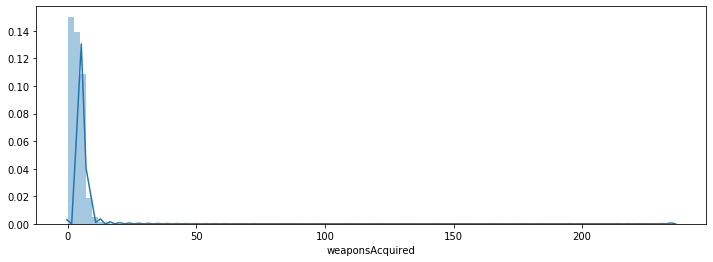

In [189]:
plt.figure(figsize = (12,4))
sns.distplot(train['weaponsAcquired'],bins = 100)
plt.show()

In [190]:
display(train[train['weaponsAcquired']>=80].shape)
train[train['weaponsAcquired']>=80]

(19, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
233643,7c8c83f5f97d0f,b33b210a52a2f8,2e8a0917a71c43,0,0,67.11,0,0,0,44,...,0.7111,91,0.00,73.1499,50.14,2072.09,0,3187.00,False,0.000000
588387,c58e3e0c2ba678,3d3e6100c07ff0,d04dbb98249f76,0,1,175.30,1,0,2,48,...,0.7500,98,0.00,178.8060,29.58,1399.44,3,1687.00,False,0.000000
1437471,8f0c855d23e4cd,679c3316056de8,fbaf1b3ae1d884,1,0,100.00,0,0,0,24,...,0.8929,97,1.03,103.0000,29.87,1895.20,0,5299.21,False,0.000000
1449293,db54cf45b9ed1c,898fccaeeb041d,484b4ae51fe80f,0,0,0.00,0,0,0,54,...,0.5600,80,0.00,0.0000,31.20,1596.00,0,653.10,False,0.000000
1592744,634a224c53444e,75fa7591d1538c,f900de1ec39fa5,9,0,1726.00,0,3,0,9,...,0.2000,11,43.47,3262.1400,20.79,3398.22,0,2888.80,False,0.130435
1834515,e927e9020f7e0d,60d6b714a7308f,8e265af296007b,1,1,26.46,0,0,1,51,...,0.9200,95,0.00,27.7830,27.30,1502.55,2,2835.00,False,0.000000
2373240,a8c150d5d3d3e2,6e1c8c5f91e060,f900de1ec39fa5,12,0,1746.00,0,1,1,11,...,0.0000,11,30.24,3299.9400,20.79,3398.22,1,275.90,False,0.062500
2442962,438cabaa5dfbdd,596c155c524725,8e0bbeec19a929,0,0,0.00,0,0,0,56,...,0.5000,91,0.00,0.0000,29.43,1278.57,0,807.60,False,0.000000
2743408,afcb46681b909f,3715298b7eea9c,4dd4d42772464f,0,4,186.90,2,0,2,18,...,0.7955,90,2.20,205.5900,49.50,1662.10,6,3318.00,False,0.000000
2749693,940b52bf12805a,4757d102ca4fbf,7ecae2cedc064f,1,3,378.90,2,0,5,7,...,0.8846,98,3.06,386.4780,27.54,1428.00,8,3641.70,False,0.000000


In [191]:
train.drop(train[train['weaponsAcquired']>=80].index, inplace=True)

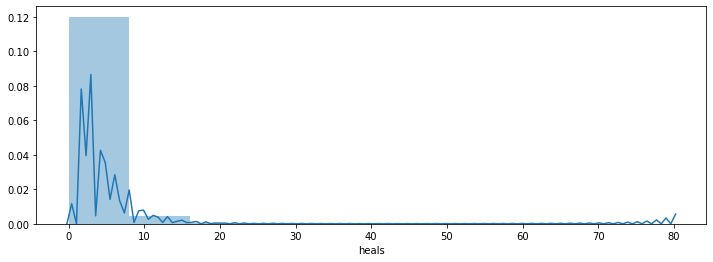

In [192]:
plt.figure(figsize = (12,4))
sns.distplot(train['heals'], bins=10)
plt.show()

In [193]:
display(train[train['heals']>=40].shape)
train[train['heals']>=40].head(10)


(135, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
18405,63ab976895d860,927eeba5614c4f,69473402649f11,0,2,0.0,0,0,47,43,...,0.9368,96,0.00,0.00,99.84,1868.88,49,6854.000,False,0.000000
54463,069ddee7c9d26a,58ab5a1ce8e06f,942416b6caf21e,1,4,182.0,0,1,43,21,...,0.9615,93,1.07,194.74,28.89,1639.24,47,3083.400,False,1.000000
126439,c45bd6917146e2,81ab9f863957cb,4335664c6716fa,0,2,0.0,0,0,52,49,...,0.8333,97,0.00,0.00,99.91,1415.22,54,1343.443,False,0.000000
259351,86910c38335c2f,2738398928d28c,7d2911e944bfaa,0,10,0.0,0,0,42,45,...,0.8646,97,0.00,0.00,99.91,1822.07,52,7444.000,False,0.000000
268747,a007734fbc6ebf,5bf702dfa1e5d4,ad6b5669d33a2c,0,5,0.0,0,0,48,43,...,0.8370,93,0.00,0.00,99.51,2009.46,53,5816.000,False,0.000000
269098,a0891dbc2950ea,dde848d90491ba,b4fd3348551b73,0,2,0.0,0,0,42,44,...,0.9259,97,0.00,0.00,28.84,1333.85,44,2439.000,False,0.000000
284195,91a2fb00455eb3,f639b09774c5b1,65b73c71653822,0,3,123.0,0,0,40,52,...,0.8276,99,0.00,124.23,30.30,1984.65,43,4848.000,False,0.000000
300204,1f4f2efc86bfcb,3d668492d1fca9,d3638466a43d38,0,6,175.0,2,1,47,25,...,0.9355,95,1.05,183.75,33.60,1425.90,53,3415.600,False,1.000000
349908,7725ad71ad2ff7,4b2a7cf86d1546,cfa2775c9ef944,3,0,2348.0,0,8,41,9,...,0.8889,41,42.93,3733.32,58.83,2857.23,41,268.800,False,0.296296
375156,d64866c78ebcb0,aa0f089ae6430c,4dbc4ebba33ec6,0,7,278.5,3,1,44,3,...,0.9630,94,4.24,295.21,29.68,1915.42,51,4927.000,False,0.250000


In [194]:
train.drop(train[train['heals']>=40].index, inplace=True)

In [195]:
train.shape

(4444776, 38)

In [196]:
print('There are {} different Match types in the dataset.'.format(train['matchType'].nunique()))

There are 16 different Match types in the dataset.


In [197]:
train = pd.get_dummies(train, columns = ['matchType'])

matchType_encoding = train.filter(regex = 'matchType')
matchType_encoding.head()

,matchType_crashfpp,matchType_crashtpp,matchType_duo,matchType_duo-fpp,matchType_flarefpp,matchType_flaretpp,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [198]:
train['groupId'] = train['groupId'].astype('category')
train['matchId'] = train['matchId'].astype('category')

train['groupId_cat'] = train['groupId'].cat.codes
train['matchId_cat'] = train['matchId'].cat.codes

In [199]:
train.drop(columns = ['groupId', 'matchId'], inplace=True)

In [200]:
train[['groupId_cat', 'matchId_cat']].head()

,groupId_cat,matchId_cat
0,613591,30085
1,827582,32751
2,843273,3143
3,1340072,45260
4,1757338,20531


In [201]:
train.drop(columns = ['Id'], inplace=True)

In [202]:
sample = 500000
df_sample = train.sample(sample)

In [203]:
df = df_sample.drop(columns = ['winPlacePerc'])
y = df_sample['winPlacePerc']

In [204]:
def split_vals(a, n : int):
    return a[:n].copy(), a[n:].copy()
val_perc = 0.12
n_valid = int(val_perc * sample)
n_trn = len(df) - n_valid
raw_train, raw_valid = split_vals(df_sample,n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

print('Sample train shape : ', X_train.shape,
     'Sample target shape : ', y_train.shape,
     'Sample validation shape: ', X_valid.shape)

Sample train shape :  (440000, 51) Sample target shape :  (440000,) Sample validation shape:  (60000, 51)


In [205]:
from sklearn.metrics import mean_absolute_error

def print_score(m : RandomForestRegressor):
    res = ['mae train : ', mean_absolute_error(m.predict(X_train), y_train), 
          'mae val : ', mean_absolute_error(m.predict(X_valid), y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [206]:
m1 = RandomForestRegressor (n_estimators= 40, min_samples_leaf=3, max_features = 'sqrt', n_jobs = -1)
m1.fit(X_train, y_train)
print_score(m1)

['mae train : ', 0.03972403109581772, 'mae val : ', 0.06325884392954777]


In [207]:
fi = rf_feat_importance(m1, df); fi[:10]

,cols,imp
21,walkDistance,0.192314
30,totalDistance,0.188984
6,killPlace,0.173184
1,boosts,0.104807
29,healsandboosts,0.102662
22,weaponsAcquired,0.056494
2,damageDealt,0.024341
25,killsNorm,0.016247
5,heals,0.015798
16,rideDistance,0.014893


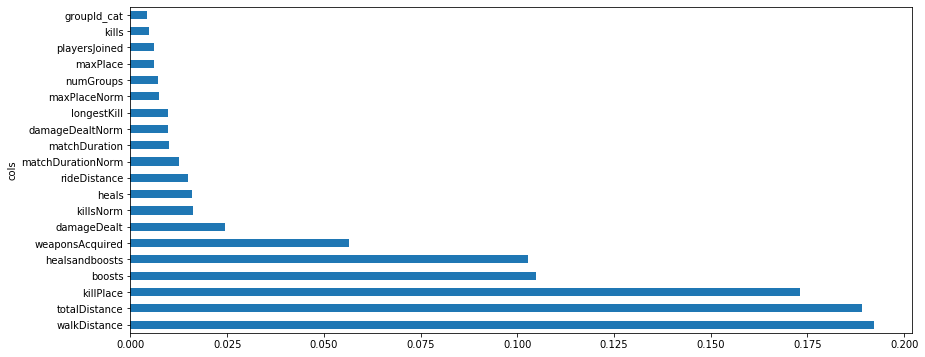

In [208]:
plot1 = fi[:20].plot('cols', 'imp', figsize = (14,6), legend = False, kind = 'barh')
plot1

In [209]:
to_keep = fi[fi.imp>0.005].cols
print('Significant features : ', len(to_keep))
to_keep

Significant features :  18


21         walkDistance
30        totalDistance
6             killPlace
1                boosts
29       healsandboosts
22      weaponsAcquired
2           damageDealt
25            killsNorm
5                 heals
16         rideDistance
28    matchDurationNorm
11        matchDuration
26      damageDealtNorm
10          longestKill
27         maxPlaceNorm
13            numGroups
12             maxPlace
24        playersJoined
Name: cols, dtype: object

In [210]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [211]:
m2 = RandomForestRegressor (n_estimators = 80, min_samples_leaf = 3, max_features = 'sqrt', n_jobs = -1)
m2.fit(X_train, y_train)
print_score(m2)

['mae train : ', 0.036626771061870886, 'mae val : ', 0.060180595503141844]


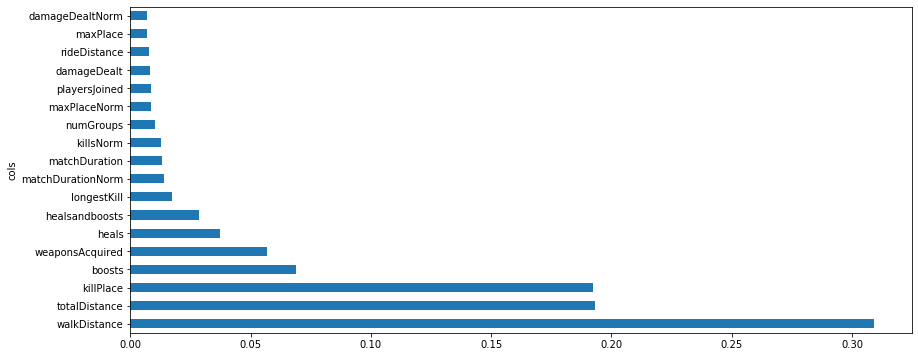

In [212]:
fi_to_keep = rf_feat_importance(m2, df_keep)
plot2 = fi_to_keep.plot('cols', 'imp', figsize = (14,6), legend= False, kind = 'barh')
plot2

[]

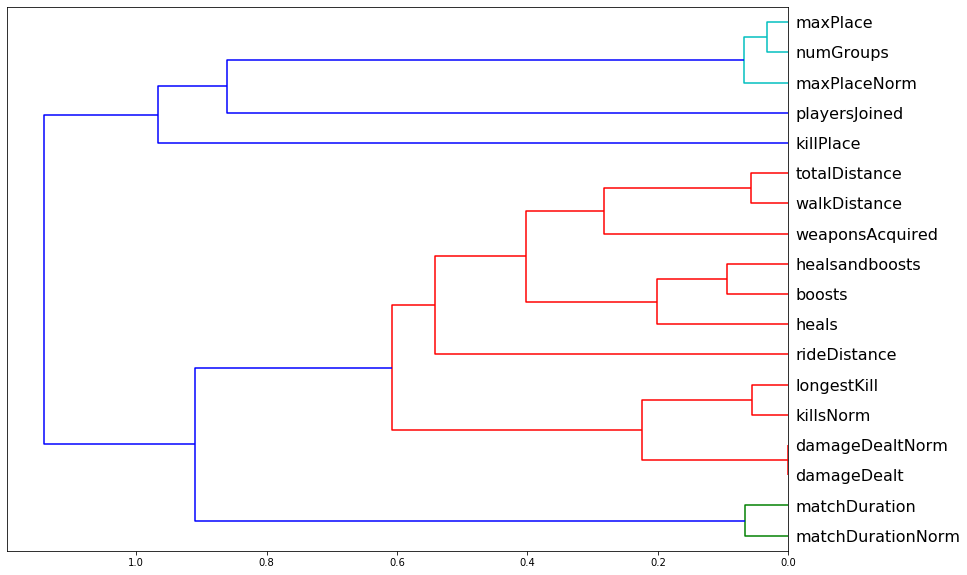

In [213]:
import scipy as scipy
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method = 'average')
fig = plt.figure(figsize = (14,10))
dendrogram = hc.dendrogram(z, labels = df_keep.columns, orientation = 'left', leaf_font_size = 16)
plt.plot()

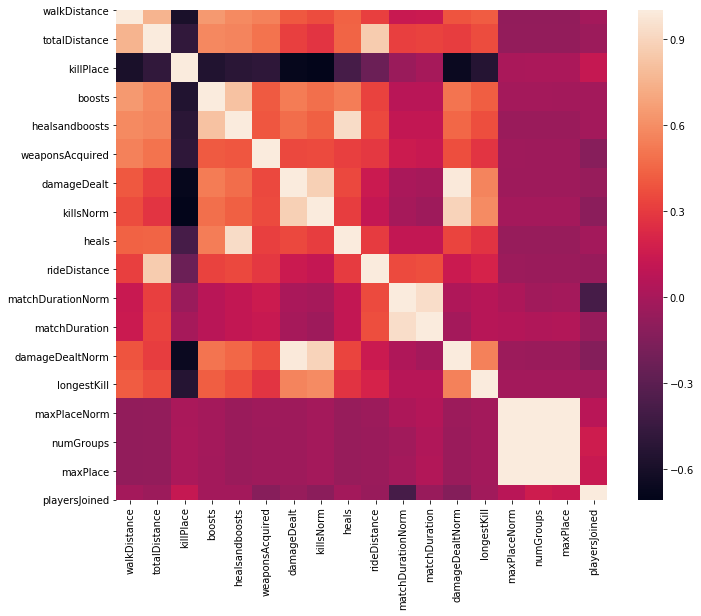

In [214]:
corr = df_keep.corr()
f, ax = plt.subplots(figsize = (11,9))
heatmap = sns.heatmap(corr)

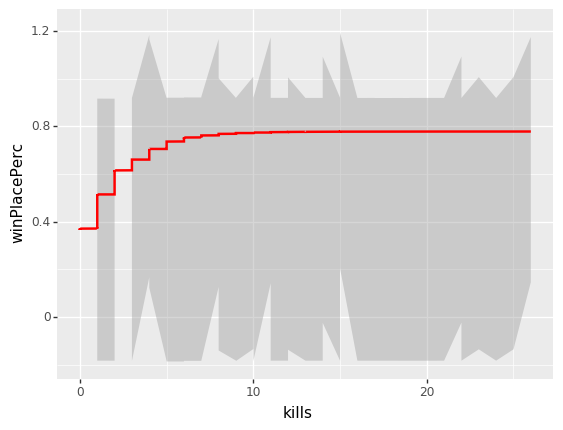

<ggplot: (-9223371879681818708)>

In [216]:
x_all = get_sample(train, 100000)
ggplot(x_all,aes('kills', 'winPlacePerc'))+stat_smooth(se=True, colour = 'red', method = 'mavg')

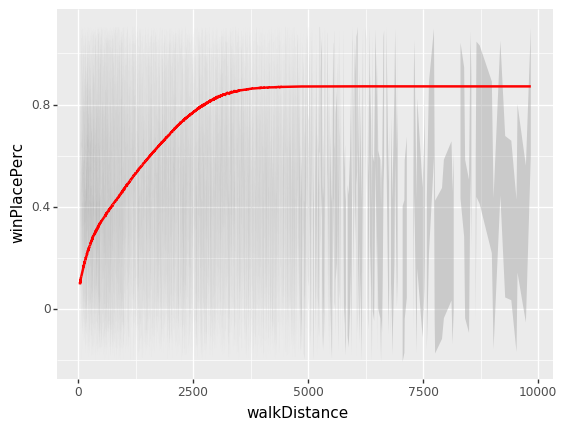

<ggplot: (-9223371879674636304)>

In [217]:
x_all = get_sample(train, 100000)
ggplot(x_all, aes('walkDistance', 'winPlacePerc'))+stat_smooth(se = True, colour = 'red', method = 'mavg')

In [218]:
val_perc_full = 0.12
n_valid_full = int(val_perc_full * len(train))
n_trn_full = len(train) - n_valid_full
df_full = train.drop(columns = ['winPlacePerc'])
y = train['winPlacePerc']
df_full = df_full[to_keep]
X_train, X_valid = split_vals (df_full, n_trn_full)
y_train, y_valid = split_vals(y, n_trn_full)
print('Sample train shape : ', X_train.shape,
     'Sample target shape : ', y_train.shape,
     'Sample validaton shape : ', X_valid.shape)

Sample train shape :  (3911403, 18) Sample target shape :  (3911403,) Sample validaton shape :  (533373, 18)


In [219]:
m3 = RandomForestRegressor(n_estimators = 70, min_samples_leaf = 3, max_features = 0.5, n_jobs = -1)
m3.fit(X_train, y_train)
print_score(m3)

['mae train : ', 0.0310308726687205, 'mae val : ', 0.056196740947683795]


In [221]:
test['headshot_rate'] = test['headshotKills'] / test['kills']
test['headshot_rate'] = test['headshot_rate'].fillna(0)
test['totalDistance'] = test['rideDistance'] + test['walkDistance'] + test['swimDistance']
test['playersJoined'] = test.groupby('matchId')['matchId'].transform('count')
test['killsNorm'] = test['kills']*((100-test['playersJoined'])/100+1)
test['damageDealtNorm'] = test['damageDealt']*((100-test['playersJoined'])/100+1)
test['maxPlaceNorm'] = test['maxPlace']*((100-test['playersJoined'])/100+1)
test['matchDurationNorm'] = test['matchDuration']*((100-test['playersJoined'])/100+1)
test['healsandboosts'] = test['heals']+test['boosts']
test['killsWithoutMoving'] = ((test['kills']>0)&(test['totalDistance']==0))

test['groupId'] = test['groupId'].astype('category')
test['matchId'] = test['matchId'].astype('category')
test['groupId_cat'] = test['groupId'].cat.codes
test['matchId_cat'] = test['matchId'].cat.codes

test_pred = test[to_keep].copy()

test_pred.fillna(0, inplace=True)
test_pred.head()

,walkDistance,totalDistance,killPlace,boosts,healsandboosts,weaponsAcquired,damageDealt,killsNorm,heals,rideDistance,matchDurationNorm,matchDuration,damageDealtNorm,longestKill,maxPlaceNorm,numGroups,maxPlace,playersJoined
0,588.0,588.0,73,0,0,1,51.46,0.00,0,0.0,2034.72,1884,55.5768,0.00,30.24,28,28,92
1,2017.0,6686.0,11,4,6,6,179.10,2.08,2,4669.0,1883.44,1811,186.2640,361.90,49.92,47,48,96
2,787.8,787.8,49,0,4,4,23.40,0.00,4,0.0,1900.58,1793,24.8040,0.00,29.68,27,28,94
3,1812.0,1812.0,54,0,0,3,65.52,0.00,0,0.0,2035.74,1834,72.7272,0.00,49.95,44,45,89
4,2963.0,2963.0,7,4,5,4,330.20,3.15,1,0.0,1392.30,1326,346.7100,60.06,29.40,27,28,95


In [222]:
predictions = np.clip(a = m3.predict(test_pred), a_min = 0.0, a_max = 1.0)
pred_df = pd.DataFrame({'Id' : test['Id'], 'winPlacePerc' : predictions})

pred_df.to_csv("submission.csv", index = False)

In [224]:
print('Head of submission : ')
display(pred_df.head())
print('Tail of submission : ')
display(pred_df.tail())

Head of submission : 


,Id,winPlacePerc
0,9329eb41e215eb,0.205490
1,639bd0dcd7bda8,0.910209
2,63d5c8ef8dfe91,0.712791
3,cf5b81422591d1,0.549579
4,ee6a295187ba21,0.907627


Tail of submission : 


,Id,winPlacePerc
1934169,a316c3a13887d5,0.742514
1934170,5312146b27d875,0.403581
1934171,fc8818b5b32ad3,0.894720
1934172,a0f91e35f8458f,0.845340
1934173,3696fc9f3a42b2,0.043081


이전 작성했던 PUBG_EDA_is_Fun과는 달리 어느정도 신빙성이 있는 Outliers 들을 제거하였다. 또한 XGBoost, LightGBM 등의 모델을 사용하지 않고 RandomForestRegressor 만을 사용하여 결과를 예측했는데, 후에 위 두 모델을 가지고 한 번더 예측을 진행해 어떤 모델을 사용하는 것이 더 좋은지에 대해 생각해야겠다. 